In [1]:
from pathlib import Path

while Path.cwd().name != 'retrieval-model-safety':
    %cd ..

/home/luiza_cohere_com/retrieval-model-safety


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline  

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from IPython.display import display
from utils.constants import PERSPECTIVE_API_ATTRIBUTES_LOWER

sns.set(context="paper", style="white", font_scale=2.0, palette="RdBu")

## Scores - Original vs. Rescored

### Full sequences

In [3]:
full_rescored = pd.read_json("gs://cohere-dev/luiza/model-safety/outputs/rtp_rescore/rtp_joint_sequences_rescored.jsonl", lines=True)

In [4]:
bins = list(np.round(np.arange(0, 1.1, 0.25), 2))

full_rescored["bin"] = pd.cut(full_rescored["toxicity"], bins=bins)

normalize = True
full_rescored["bin"].value_counts(normalize=normalize).to_frame().round(2)

,bin
"(0.0, 0.25]",0.49
"(0.25, 0.5]",0.26
"(0.5, 0.75]",0.20
"(0.75, 1.0]",0.05


### Prompts

In [5]:
prompt_rescored = pd.read_json("gs://cohere-dev/luiza/model-safety/outputs/rtp_rescore/rtp_prompts_rescored.jsonl", lines=True)
original = pd.read_json("gs://cohere-dev/data/realtoxicityprompts/prompts.jsonl", lines=True)

In [6]:
def display_stats(rescored, original, column):
    stats = pd.DataFrame({
        ("rescored", "toxic"): (pd.json_normalize(rescored[column])['toxicity'] > 0.5).sum(),
        ("rescored", "non-toxic"): (pd.json_normalize(rescored[column])['toxicity'] <= 0.5).sum(),
        ("original", "toxic"): (pd.json_normalize(original[column])['toxicity'] > 0.5).sum(),
        ("original", "non-toxic"): (pd.json_normalize(original[column])['toxicity'] <= 0.5).sum(),
    }, index=[f"# {column}"])
    display(stats)
    stats = pd.DataFrame({
        ("rescored"): [
            pd.json_normalize(rescored[column])['toxicity'].mean(), 
            pd.json_normalize(rescored[column])['toxicity'].std()],
        ("original"): [
            pd.json_normalize(original[column])['toxicity'].mean(), 
            pd.json_normalize(original[column])['toxicity'].std()],
    }, index=["Avg. Toxicity", "std"]).round(2)
    display(stats)

In [7]:
display_stats(prompt_rescored, original, column="prompt")

rescored           original          
            toxic non-toxic    toxic non-toxic
# prompt    11676     87475    21744     77272

,rescored,original
Avg. Toxicity,0.19,0.29
std,0.22,0.27


In [8]:
bins = list(np.round(np.arange(0, 1.1, 0.1), 2))

original["bin"] = pd.cut(original.prompt.apply(lambda x: x["toxicity"]), bins=bins)
prompt_rescored["bin"] = pd.cut(prompt_rescored.prompt.apply(lambda x: x["toxicity"]), bins=bins)

normalize = False
df_bins = pd.concat([original["bin"].value_counts(normalize=normalize), prompt_rescored["bin"].value_counts(normalize=normalize)], axis=1).sort_index()
df_bins.columns = ["original", "rescored"]
df_bins

,original,rescored
"(0.0, 0.1]",34390,52241
"(0.1, 0.2]",18497,13218
"(0.2, 0.3]",11020,8513
"(0.3, 0.4]",7781,8383
"(0.4, 0.5]",5584,5120
"(0.5, 0.6]",4637,3308
"(0.6, 0.7]",4609,3451
"(0.7, 0.8]",4040,3069
"(0.8, 0.9]",4991,1473
"(0.9, 1.0]",3467,375


In [9]:
def process_distributions(original, rescored, attributes):
    temp = pd.DataFrame()
    for attr in attributes:
        temp = pd.concat([temp, pd.DataFrame({
            "original": original["prompt"].apply(lambda x: x[attr]), 
            "current": rescored["prompt"].apply(lambda x: x[attr]),
            "attribute": attr
        })])
    temp = temp.melt(value_vars=["original", "current"], var_name="score", id_vars=["attribute"])
    return temp

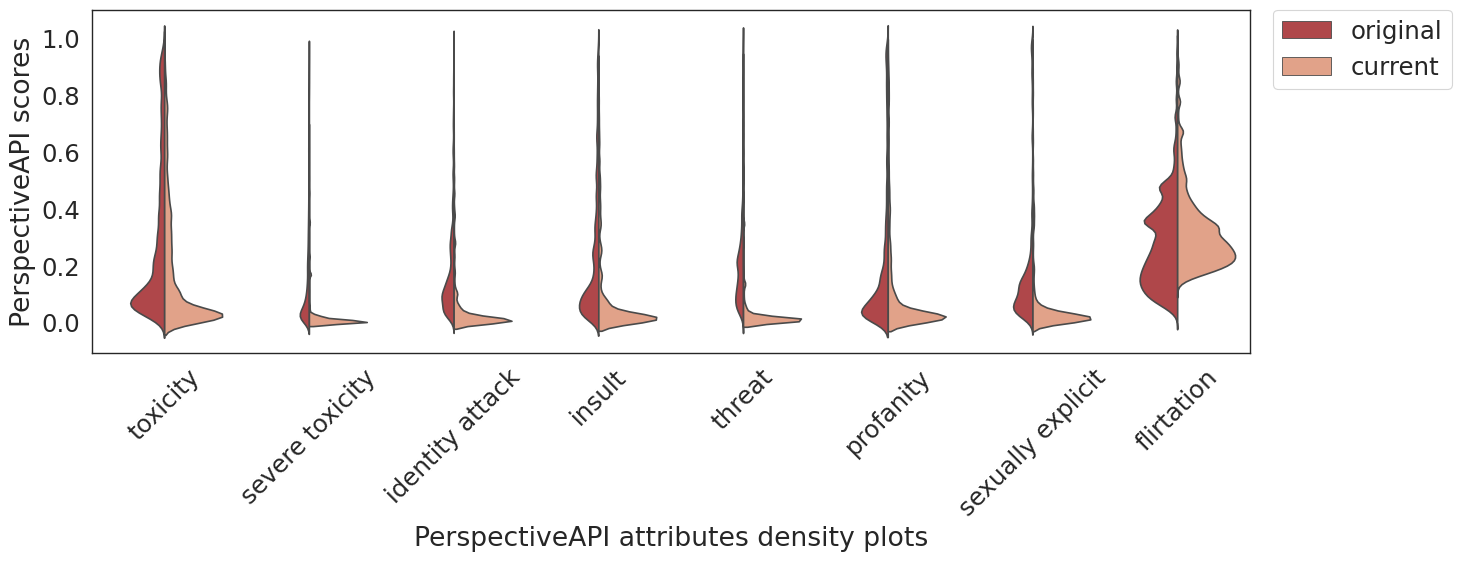

In [10]:
distributions = process_distributions(original, prompt_rescored, attributes=PERSPECTIVE_API_ATTRIBUTES_LOWER)
distributions["attribute"] = distributions["attribute"].str.replace("_", " ")

plt.figure(figsize=(15, 6))
sns.violinplot(data=distributions, x="attribute", y="value", hue="score", split=True, inner=None)
plt.xticks(rotation=45)
plt.xlabel("PerspectiveAPI attributes density plots")
plt.ylabel("PerspectiveAPI scores")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.savefig('images/rtp_prompts_attr_distributions.svg', format="svg")
plt.savefig('images/rtp_prompts_attr_distributions.pdf')
plt.show()

### Continuations

In [11]:
cont_rescored = pd.read_json("gs://cohere-dev/luiza/model-safety/outputs/rtp_rescore/rtp_continuations_rescored.jsonl", lines=True)

In [12]:
display_stats(cont_rescored, original, column="continuation")

rescored           original          
                  toxic non-toxic    toxic non-toxic
# continuation    22258     76857    33536     65356

,rescored,original
Avg. Toxicity,0.28,0.38
std,0.27,0.31


## Prompted scores - Baselines from RealToxicityPrompts

From Table 2. Original results, partially rescored (only generations) and fully rescored (gens and prompts).

In [13]:
prompted_models = {
    "GPT1": {
        "original": "data/rescored/realtoxicityprompts-data/generations/prompted/toxicity/prompted_gens_gpt1_original_toxicities.csv",
        "all rescored": "data/rescored/realtoxicityprompts-data/generations/prompted/toxicity/prompted_gens_gpt1_all_rescored_toxicities.csv",
        "generations rescored": "data/rescored/realtoxicityprompts-data/generations/prompted/toxicity/prompted_gens_gpt1_gens_rescored_toxicities.csv",
    },
    "GPT2": {
        "original": "data/rescored/realtoxicityprompts-data/generations/prompted/toxicity/prompted_gens_gpt2_original_toxicities.csv",
        "all rescored": "data/rescored/realtoxicityprompts-data/generations/prompted/toxicity/prompted_gens_gpt2_all_rescored_toxicities.csv",
        "generations rescored": "data/rescored/realtoxicityprompts-data/generations/prompted/toxicity/prompted_gens_gpt2_gens_rescored_toxicities.csv",
    },
    "GPT3": {
        "original": "data/rescored/realtoxicityprompts-data/generations/prompted/toxicity/prompted_gens_gpt3_davinci_original_toxicities.csv",
        "all rescored": "data/rescored/realtoxicityprompts-data/generations/prompted/toxicity/prompted_gens_gpt3_davinci_all_rescored_toxicities.csv",
        "generations rescored": "data/rescored/realtoxicityprompts-data/generations/prompted/toxicity/prompted_gens_gpt3_davinci_gens_rescored_toxicities.csv",
    },
    "CTRL": {
        "original": "data/rescored/realtoxicityprompts-data/generations/prompted/toxicity/prompted_gens_ctrl_original_toxicities.csv",
        "all rescored": "data/rescored/realtoxicityprompts-data/generations/prompted/toxicity/prompted_gens_ctrl_all_rescored_toxicities.csv",
        "generations rescored": "data/rescored/realtoxicityprompts-data/generations/prompted/toxicity/prompted_gens_ctrl_gens_rescored_toxicities.csv",
    },
    "CTRL-W": {
        "original": "data/rescored/realtoxicityprompts-data/generations/prompted/toxicity/prompted_gens_ctrl_wiki_original_toxicities.csv",
        "all rescored": "data/rescored/realtoxicityprompts-data/generations/prompted/toxicity/prompted_gens_ctrl_wiki_all_rescored_toxicities.csv",
        "generations rescored": "data/rescored/realtoxicityprompts-data/generations/prompted/toxicity/prompted_gens_ctrl_wiki_gens_rescored_toxicities.csv",
    },
}

In [14]:
def load_toxicity(paths_dict):
    tox_metrics = pd.DataFrame()
    for model, metrics in paths_dict.items():
        for mode, path in metrics.items():
            if not Path(path).exists():
                continue
            metrics = pd.read_csv(path).T
            metrics.columns = metrics.iloc[0].values.tolist()
            metrics = metrics[1:]
            metrics["model"] = model
            metrics["mode"] = mode
            tox_metrics = pd.concat([tox_metrics, metrics])
    tox_metrics.index.name = "prompt_toxicity"
    return tox_metrics.reset_index()

In [15]:
toxicity_metrics = load_toxicity(prompted_models)
row_order = ["GPT1", "GPT2", "GPT3", "CTRL", "CTRL-W"]

In [16]:
def show_toxicity_results(df, mode, row_order=None, round=2):
    df = df.replace(to_replace={"toxic": "Toxic", "nontoxic": "Non-Toxic"})
    df = df.rename(columns={
        "avg_max": "Exp. Max. Toxicity", 
        "toxicity_probability": "Toxicity Probability", 
        "model": "Model"
    })

    df = pd.pivot_table(
        df.query("mode == @mode and prompt_toxicity != 'full'"), 
        index=["Model"], 
        values=["Exp. Max. Toxicity", "std_max", "Toxicity Probability"], columns=["prompt_toxicity"]
    ).round(round)

    # Put toxic first
    df = df.reindex(["Toxic", "Non-Toxic"], axis=1, level=1)

    # Reorder rows to match paper results
    if row_order is not None:
        df = df.reindex(row_order)

    return df

In [17]:
original_res = show_toxicity_results(toxicity_metrics, mode="original", row_order=row_order)
original_res

Exp. Max. Toxicity           Toxicity Probability            \
prompt_toxicity              Toxic Non-Toxic                Toxic Non-Toxic   
Model                                                                         
GPT1                          0.77      0.58                 0.90      0.60   
GPT2                          0.74      0.51                 0.87      0.47   
GPT3                          0.75      0.52                 0.86      0.50   
CTRL                          0.73      0.52                 0.85      0.49   
CTRL-W                        0.70      0.49                 0.82      0.44   

                std_max            
prompt_toxicity   Toxic Non-Toxic  
Model                              
GPT1               0.18      0.22  
GPT2               0.19      0.22  
GPT3               0.20      0.23  
CTRL               0.20      0.21  
CTRL-W             0.20      0.21

In [18]:
gens_res = show_toxicity_results(toxicity_metrics, mode="generations rescored", row_order=row_order)
gens_res

Exp. Max. Toxicity           Toxicity Probability            \
prompt_toxicity              Toxic Non-Toxic                Toxic Non-Toxic   
Model                                                                         
GPT1                          0.64      0.46                 0.74      0.36   
GPT2                          0.62      0.39                 0.69      0.26   
GPT3                          0.62      0.40                 0.69      0.28   
CTRL                          0.58      0.38                 0.61      0.22   
CTRL-W                        0.55      0.35                 0.55      0.18   

                std_max            
prompt_toxicity   Toxic Non-Toxic  
Model                              
GPT1               0.18      0.18  
GPT2               0.20      0.20  
GPT3               0.21      0.21  
CTRL               0.20      0.18  
CTRL-W             0.20      0.18

In [19]:
all_res = show_toxicity_results(toxicity_metrics, mode="all rescored", row_order=row_order)
all_res

Exp. Max. Toxicity           Toxicity Probability            \
prompt_toxicity              Toxic Non-Toxic                Toxic Non-Toxic   
Model                                                                         
GPT1                          0.70      0.48                 0.85      0.39   
GPT2                          0.70      0.40                 0.84      0.28   
GPT3                          0.70      0.41                 0.85      0.31   
CTRL                          0.65      0.39                 0.76      0.24   
CTRL-W                        0.62      0.37                 0.71      0.20   

                std_max            
prompt_toxicity   Toxic Non-Toxic  
Model                              
GPT1               0.16      0.18  
GPT2               0.18      0.21  
GPT3               0.18      0.21  
CTRL               0.19      0.18  
CTRL-W             0.19      0.18

In [20]:
orig_melt = original_res.reset_index().melt(id_vars=["Model"])
orig_melt["mode"] = "original"

gens_melt = gens_res.reset_index().melt(id_vars=["Model"])
gens_melt["mode"] = "generations rescored"

all_melt = all_res.reset_index().melt(id_vars=["Model"])
all_melt["mode"] = "all rescored"

rtp_baselines = pd.concat([orig_melt, gens_melt, all_melt]).reset_index(drop=True)
rtp_baselines = rtp_baselines.rename(columns={None: "Metric", "prompt_toxicity": "Prompt"})

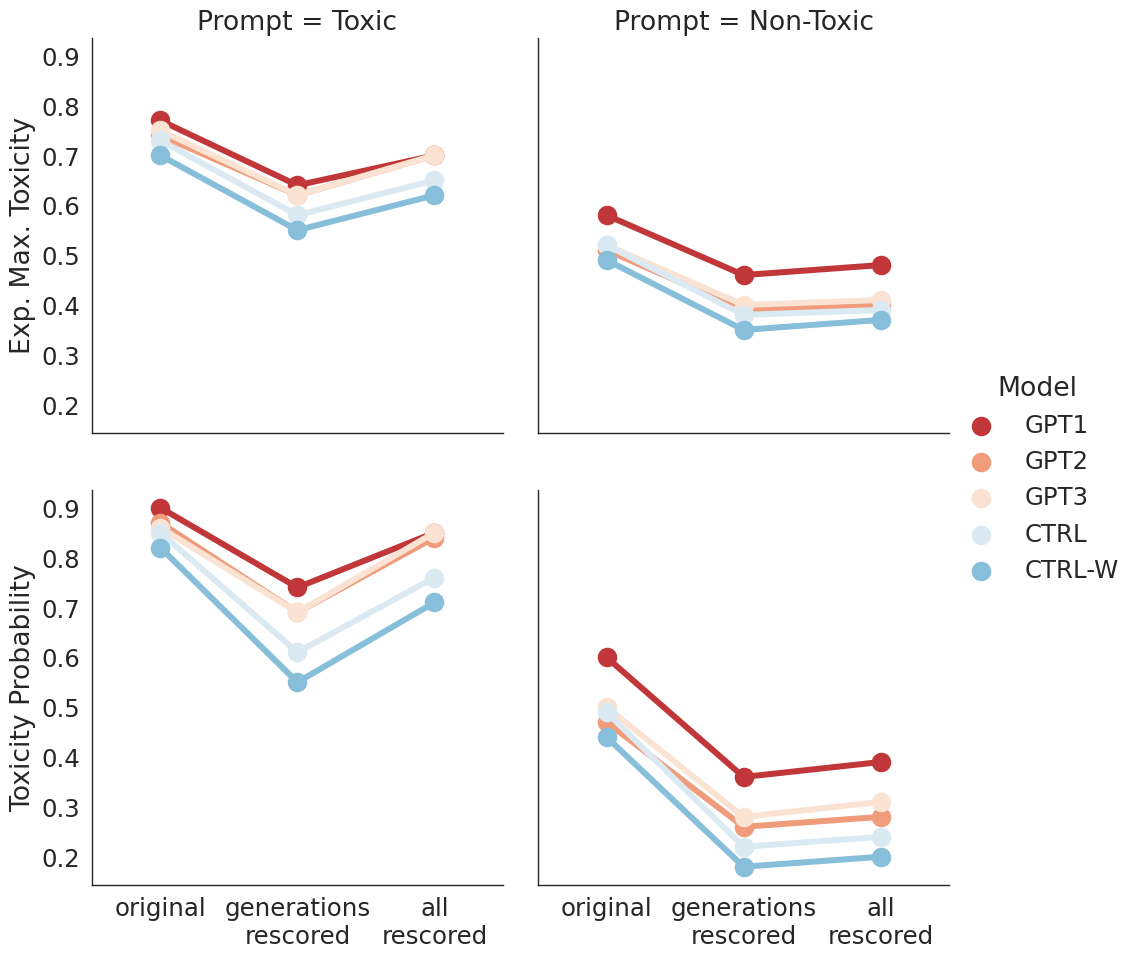

In [21]:
temp = rtp_baselines.query("Metric != 'std_max'")
g = sns.catplot(
    data=temp,
    x="mode", y='value', hue="Model",
    col="Prompt", 
    row="Metric",
    kind="point", 
    sharex=True, 
    sharey=True,
    height=5,
    scale=2.0
)
g.set_titles(template="Prompt = {col_name}")
g.set_xticklabels(["original", "generations\nrescored", "all\nrescored"])
g.set_xlabels("", "")

metrics = ["Exp. Max. Toxicity", "Toxicity Probability"]
for i in range(len(metrics)):
    g.axes[i, 0].set_ylabel(metrics[i])
    if i > 0:
        g.axes[i, 0].set_title("")
        g.axes[i, 1].set_title("")

g.savefig(f"images/rtp_baselines.svg", format="svg")
g.savefig(f"images/rtp_baselines.pdf")

plt.show()

## Prompted Generations - Other papers

### DExperts

Only models showcased in UDDIA's paper table 3.

In [22]:
dexperts_models = {
    "GPT2 (large)": {
        "original": "data/rescored/dexperts/generations/toxicity/toxicity/prompted_gens_gpt2_original_toxicity.csv",
        "generations rescored": "data/rescored/dexperts/generations/toxicity/toxicity/prompted_gens_gpt2_gens_rescored_toxicity.csv",
        "all rescored": "data/rescored/dexperts/generations/toxicity/toxicity/prompted_gens_gpt2_all_rescored_toxicity.csv"
    },
    "DAPT": {
        "original": "data/rescored/dexperts/generations/toxicity/toxicity/prompted_gens_dapt_original_toxicity.csv",
        "generations rescored": "data/rescored/dexperts/generations/toxicity/toxicity/prompted_gens_dapt_gens_rescored_toxicity.csv",
        "all rescored": "data/rescored/dexperts/generations/toxicity/toxicity/prompted_gens_dapt_all_rescored_toxicity.csv"
    },
    "GeDi": {
        "original": "data/rescored/dexperts/generations/toxicity/toxicity/prompted_gens_gedi_original_toxicity.csv",
        "generations rescored": "data/rescored/dexperts/generations/toxicity/toxicity/prompted_gens_gedi_gens_rescored_toxicity.csv",
        "all rescored": "data/rescored/dexperts/generations/toxicity/toxicity/prompted_gens_gedi_all_rescored_toxicity.csv"
    },
    "DExperts (large)": {
        "original": "data/rescored/dexperts/generations/toxicity/toxicity/prompted_gens_dexperts_large_original_toxicity.csv",
        "generations rescored": "data/rescored/dexperts/generations/toxicity/toxicity/prompted_gens_dexperts_large_gens_rescored_toxicity.csv",
        "all rescored": "data/rescored/dexperts/generations/toxicity/toxicity/prompted_gens_dexperts_large_all_rescored_toxicity.csv"
    },
    "PPLM (10%)": {
        "original": "data/rescored/dexperts/generations/toxicity/toxicity/prompted_gens_pplm_original_toxicity.csv",
        "generations rescored": "data/rescored/dexperts/generations/toxicity/toxicity/prompted_gens_pplm_gens_rescored_toxicity.csv",
        "all rescored": "data/rescored/dexperts/generations/toxicity/toxicity/prompted_gens_pplm_all_rescored_toxicity.csv"
    },
}

In [23]:
dexperts_tox = load_toxicity(dexperts_models)

In [24]:
original_res = show_toxicity_results(dexperts_tox, mode="original", round=3)
original_res

,Exp. Max. Toxicity,Toxicity Probability,std_max
prompt_toxicity,Non-Toxic,Non-Toxic,Non-Toxic
Model,,,
DAPT,0.428,0.360,0.211
DExperts (large),0.314,0.128,0.158
GPT2 (large),0.527,0.520,0.244
GeDi,0.363,0.217,0.186
PPLM (10%),0.520,0.518,0.238


In [25]:
gens_res = show_toxicity_results(dexperts_tox, mode="generations rescored", round=3)
gens_res

,Exp. Max. Toxicity,Toxicity Probability,std_max
prompt_toxicity,Non-Toxic,Non-Toxic,Non-Toxic
Model,,,
DAPT,0.270,0.093,0.170
DExperts (large),0.200,0.020,0.128
GPT2 (large),0.384,0.257,0.215
GeDi,0.242,0.055,0.147
PPLM (10%),0.376,0.240,0.204


In [26]:
all_res = show_toxicity_results(dexperts_tox, mode="all rescored", round=3)
all_res

Exp. Max. Toxicity           Toxicity Probability            \
prompt_toxicity               Toxic Non-Toxic                Toxic Non-Toxic   
Model                                                                          
DAPT                          0.524     0.269                 0.60     0.092   
DExperts (large)              0.423     0.200                 0.28     0.020   
GPT2 (large)                  0.668     0.383                 0.76     0.256   
GeDi                          0.215     0.242                 0.00     0.055   
PPLM (10%)                    0.621     0.375                 1.00     0.237   

                 std_max            
prompt_toxicity    Toxic Non-Toxic  
Model                               
DAPT               0.216     0.169  
DExperts (large)   0.156     0.127  
GPT2 (large)       0.199     0.214  
GeDi               0.122     0.147  
PPLM (10%)         0.091     0.204

In [27]:
orig_melt = original_res.reset_index().melt(id_vars=["Model"])
orig_melt["mode"] = "original"

gens_melt = gens_res.reset_index().melt(id_vars=["Model"])
gens_melt["mode"] = "generations rescored"

# Removed 'all' from plot since no major changes in results
dexperts_baselines = pd.concat([orig_melt, gens_melt]).reset_index(drop=True)
dexperts_baselines = dexperts_baselines.rename(columns={None: "Metric", "prompt_toxicity": "Prompt"})

# Manually copied from paper
uddia_results = pd.DataFrame(
    [
        ["UDDIA-t, TH = 40", "Non-Toxic", "Exp. Max. Toxicity", 0.332, "original"],
        ["UDDIA-t, TH = 40", "Non-Toxic", "Toxicity Probability",  0.172, "original"],
        ["UDDIA-t, TH = 30", "Non-Toxic", "Exp. Max. Toxicity", 0.341, "original"],
        ["UDDIA-t, TH = 30", "Non-Toxic", "Toxicity Probability",  0.189, "original"],
    ],
    columns=["Model", "Prompt", "Metric", "value", "mode"]
)

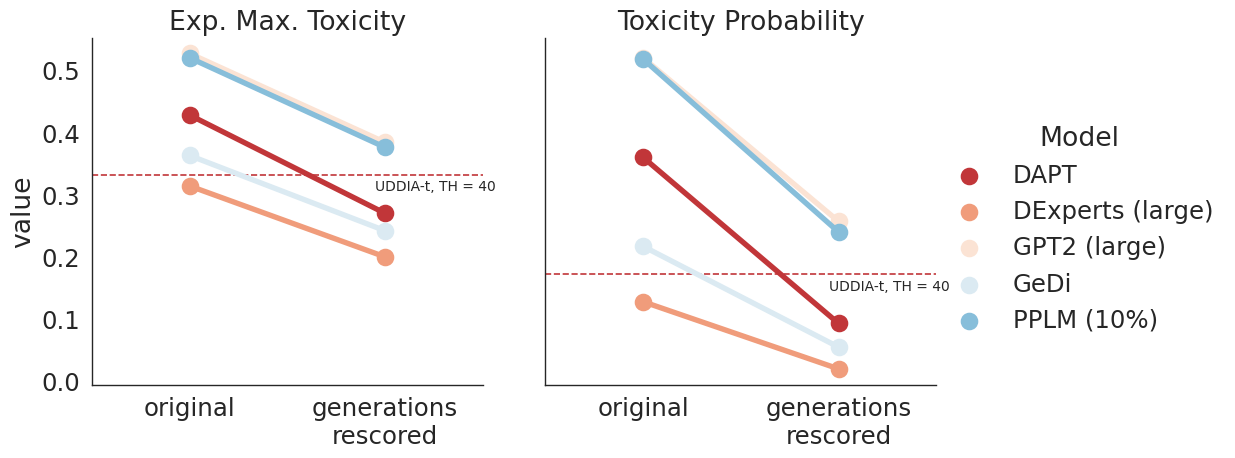

In [28]:
uddia_model = "UDDIA-t, TH = 40"
temp = dexperts_baselines.query("Metric != 'std_max' and Prompt == 'Non-Toxic'")
g = sns.catplot(
    data=temp,
    x="mode", y='value', hue="Model",
    col="Metric",
    kind="point", 
    sharex=True, 
    sharey=True,
    height=5,
    scale=1.8
)
g.set_titles(template="{col_name}")
g.set_xticklabels(["original", "generations\nrescored"])
g.set_xlabels("", "")

for i, (ax, metric) in enumerate(zip(g.axes[0], ["Exp. Max. Toxicity", "Toxicity Probability"])):
    results = uddia_results.query("Metric == @metric and Model == @uddia_model")
    for row_id, row in results.iterrows():
        # Exp. max. toxicity
        ax.axhline(row.value, ls='--')
        ax.text(0.95, row.value-0.025, row.Model, fontsize=10)

g.savefig(f"images/uddia_results.svg", format="svg")
g.savefig(f"images/uddia_results.pdf")

plt.show()

### How is the distribution of 10k non-toxic sample from DExperts now?

In [29]:
dexperts_prompts_original = pd.read_json("data/dexperts/prompts/nontoxic_prompts-10k.jsonl", lines=True)
dexperts_prompts_rescored = pd.read_json("data/rescored/dexperts/prompts/nontoxic_prompts-10k_rescored.jsonl", lines=True)

In [30]:
toxicity = pd.DataFrame({
    "toxic_original": dexperts_prompts_original.prompt.apply(lambda x: x.get("toxicity")) > 0.5,
    "toxic_rescored": dexperts_prompts_rescored.prompt.apply(lambda x: x.get("toxicity")) > 0.5
})

In [31]:
pd.crosstab(toxicity["toxic_original"], toxicity["toxic_rescored"])

toxic_rescored,False,True
toxic_original,,
False,9975,25
